## 課題① Kickstarter Projects
- クラウドファンデイングが成功するか(state)を予測

- 交差検証、ホールドアウト法などで汎化性能を確認する
- 欠測値と異常値を確認し、適切に処理する
- DAY2で学んだアルゴリズムを利用してモデルをつくり、DAY1宿題提出時の精度と比較する
- 交差検証によるパラメータチューニングを行う
- パラメータチューニング後のモデルによって、精度および結果の評価を行う
- その他、精度の向上ができるような処理に取り組み、精度を上げる

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数

### 1. データの読み込み

ks-projects-201801.csvのColumnについて

|No|列名|意味|目的変数|説明変数|メモ|
| ---: | :---| :--- | :---: | :---: | :--- |
|1|ID|id|-|-|分析に不要|
|2|name|プロジェクト名|-|-|-|
|3|category|サブカテゴリ|-|-|-|
|4|main_category|メインカテゴリ|-|-|-|
|5|currency|通貨|-|-|-|
|6|deadline|クラウドファンディングの締切日|-|-|deadline～launchedの期間(日数)を計算|
|7|goal|目標額|-|-|usd_goal_realの方が通貨が統一されているため使用しない|
|8|launched|開始日時|-|-|deadline～launchedの期間(日数)を計算|
|9|pledged|出資金額。最終的に集まった金額|-|×|※予測に使えない|
|10|state|状態|〇|-|-|
|11|backers|出資者数。出資した人数|-|×|※予測に使えない|
|12|country|国|-|-|大陸別に変換|
|13|usd pledged|米ドルでの出資金額(KSによる変換)|-|×|※予測に使えない|
|14|usd_pledged_real|米ドルでの出資金額(fixer.io apiによる変換)|-|×|※予測に使えない|
|15|usd_goal_real|米ドルでの目標額|-|-|-|

In [2]:
df_kp = pd.read_csv("./ks-projects-201801.csv")

display(df_kp.head())
#統計量をすべて出力
#平均=mean
#std=標準偏差
display(df_kp.describe())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [3]:
#欠損値チェック
df_kp.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [4]:
df_kp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


In [5]:
#categoryの要素の個数を表示
df_kp.category.value_counts()

Product Design       22314
Documentary          16139
Music                15727
Tabletop Games       14180
Shorts               12357
Video Games          11830
Food                 11493
Film & Video         10108
Fiction               9169
Fashion               8554
Nonfiction            8318
Art                   8253
Apparel               7166
Theater               7057
Technology            6930
Rock                  6758
Children's Books      6756
Apps                  6345
Publishing            6018
Webseries             5762
Photography           5752
Indie Rock            5657
Narrative Film        5188
Web                   5153
Comics                4996
Crafts                4664
Country & Folk        4451
Design                4199
Hip-Hop               3912
Hardware              3663
                     ...  
Couture                275
Blues                  268
Animals                255
Fabrication Tools      250
Makerspaces            238
Printing               238
M

In [6]:
#stateの要素の個数を表示
df_kp.state.value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

#### stateの値
- failed：失敗
- successful：成功
- canceled：キャンセル
- undefined：未定義
- live：実行中
- suspended：一時停止

### 2.stateが 成功(successful) 又は 失敗(failed) のデータのみを取得

In [7]:
df_kp=df_kp[(df_kp.state == 'failed') | (df_kp.state == 'successful')]
display(df_kp.head())
display(df_kp.describe())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,successful,224,US,52375.0,52375.0,50000.00


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.316750e+05,3.316750e+05,3.316750e+05,331675.000000,3.314650e+05,3.316750e+05,3.316750e+05
mean,1.074271e+09,4.425157e+04,1.058400e+04,116.381581,7.684569e+03,9.943461e+03,4.151000e+04
std,6.191924e+08,1.117917e+06,1.015917e+05,965.427268,8.320938e+04,9.673293e+04,1.108930e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.371725e+08,2.000000e+03,5.000000e+01,2.000000,2.500000e+01,5.000000e+01,2.000000e+03
50%,1.074573e+09,5.000000e+03,7.820000e+02,15.000000,5.020000e+02,7.880000e+02,5.000000e+03
75%,1.609844e+09,1.500000e+04,4.657000e+03,63.000000,3.421000e+03,4.608000e+03,1.500000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [8]:
#stateの要素の個数を表示
df_kp.state.value_counts()

failed        197719
successful    133956
Name: state, dtype: int64

### 3.stateの値を1(成功)、0(失敗)に変更

In [9]:
#stateがsuccessful(成功)の場合、stateに1を設定
#stateがfailed(失敗)の場合、stateに0を設定
df_kp.loc[df_kp.state=='successful',["state"]]=1
df_kp.loc[df_kp.state=='failed',["state"]]=0
display(df_kp.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,0,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,0,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,0,1,US,1.0,1.0,5000.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,1,224,US,52375.0,52375.0,50000.00


### 4.クラウドファンディングの期間（日数）を計算
- deadline(締切日)～launched(開始日時)の期間

In [10]:
#deadline(締切日)とlaunched(開始日時)を時刻型に変換
df_kp['deadline'] = pd.to_datetime(df_kp['deadline'], format='%Y-%m-%d %H:%M:%S')
df_kp['launched'] = pd.to_datetime(df_kp['launched'], format='%Y-%m-%d %H:%M:%S')

#クラウドファンディングの期間（日数）を計算
df_kp['period']=(df_kp['deadline'] - df_kp['launched']).dt.days

display(df_kp.head())
display(df_kp.describe())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,period
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,0,GB,0.0,0.0,1533.95,58
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,0,15,US,100.0,2421.0,30000.00,59
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,0,3,US,220.0,220.0,45000.00,44
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,0,1,US,1.0,1.0,5000.00,29
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,1,224,US,52375.0,52375.0,50000.00,34


,ID,goal,pledged,state,backers,usd pledged,usd_pledged_real,usd_goal_real,period
count,3.316750e+05,3.316750e+05,3.316750e+05,331675.000000,331675.000000,3.314650e+05,3.316750e+05,3.316750e+05,331675.000000
mean,1.074271e+09,4.425157e+04,1.058400e+04,0.403877,116.381581,7.684569e+03,9.943461e+03,4.151000e+04,32.954902
std,6.191924e+08,1.117917e+06,1.015917e+05,0.490674,965.427268,8.320938e+04,9.673293e+04,1.108930e+06,12.713329
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000e-02,0.000000
25%,5.371725e+08,2.000000e+03,5.000000e+01,0.000000,2.000000,2.500000e+01,5.000000e+01,2.000000e+03,29.000000
50%,1.074573e+09,5.000000e+03,7.820000e+02,0.000000,15.000000,5.020000e+02,7.880000e+02,5.000000e+03,29.000000
75%,1.609844e+09,1.500000e+04,4.657000e+03,1.000000,63.000000,3.421000e+03,4.608000e+03,1.500000e+04,35.000000
max,2.147476e+09,1.000000e+08,2.033899e+07,1.000000,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08,91.000000


### 5.不要な列を除く
- 不要なデータ：ID
- 予測に使えない：pledged, backers, usd pledged, usd_pledged_real
- goal：usd_goal_realと重複しているため
- deadline、launched：日数に変換したため

- Day1との違い：name、categoryを削除しない

In [11]:
#不要列の削除
df_kp=df_kp.drop(columns=['ID', 'deadline', 'goal', 'launched', 'pledged', 'backers' ,'usd pledged', 'usd_pledged_real'])
display(df_kp.head())
display(df_kp.describe())

,name,category,main_category,currency,state,country,usd_goal_real,period
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,0,GB,1533.95,58
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,0,US,30000.00,59
2,Where is Hank?,Narrative Film,Film & Video,USD,0,US,45000.00,44
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,0,US,5000.00,29
5,Monarch Espresso Bar,Restaurants,Food,USD,1,US,50000.00,34


,state,usd_goal_real,period
count,331675.000000,3.316750e+05,331675.000000
mean,0.403877,4.151000e+04,32.954902
std,0.490674,1.108930e+06,12.713329
min,0.000000,1.000000e-02,0.000000
25%,0.000000,2.000000e+03,29.000000
50%,0.000000,5.000000e+03,29.000000
75%,1.000000,1.500000e+04,35.000000
max,1.000000,1.663614e+08,91.000000


In [12]:
#欠損値チェック
df_kp.isnull().sum()

name             3
category         0
main_category    0
currency         0
state            0
country          0
usd_goal_real    0
period           0
dtype: int64

In [13]:
df_kp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 8 columns):
name             331672 non-null object
category         331675 non-null object
main_category    331675 non-null object
currency         331675 non-null object
state            331675 non-null int64
country          331675 non-null object
usd_goal_real    331675 non-null float64
period           331675 non-null int64
dtypes: float64(1), int64(2), object(5)
memory usage: 22.8+ MB


In [14]:
#main_categoryの要素の個数を表示
df_kp.main_category.value_counts()

Film & Video    56527
Music           45949
Publishing      35445
Games           28521
Technology      27050
Art             25641
Design          25364
Food            22054
Fashion         19775
Theater         10242
Comics           9878
Photography      9689
Crafts           7818
Journalism       4149
Dance            3573
Name: main_category, dtype: int64

In [15]:
#currencyの要素の個数を表示
df_kp.currency.value_counts()

USD    261511
GBP     29476
EUR     14378
CAD     12375
AUD      6621
SEK      1510
MXN      1411
NZD      1274
DKK       929
CHF       652
NOK       584
HKD       477
SGD       454
JPY        23
Name: currency, dtype: int64

In [16]:
#countryの要素の個数を表示
df_kp.country.value_counts()

US      261360
GB       29454
CA       12370
AU        6616
DE        3436
FR        2520
NL        2411
IT        2369
ES        1873
SE        1509
MX        1411
NZ        1274
DK         926
IE         683
CH         652
NO         582
BE         523
AT         485
HK         477
SG         454
N,0"       210
LU          57
JP          23
Name: country, dtype: int64

### 6.countryの「N,0"」を「NO」に変換

In [17]:
#CSVデータを確認すると「N,0"」のデータは「"(ダブルクォーテーション)」の出力が失敗していると思われるため、
#countryの「N,0"」を「NO（ノルウェー）」と判断して「NO」に変換
df_kp.loc[df_kp.country=='N,0"',["country"]]='NO'

#countryの要素の個数を表示
df_kp.country.value_counts()

US    261360
GB     29454
CA     12370
AU      6616
DE      3436
FR      2520
NL      2411
IT      2369
ES      1873
SE      1509
MX      1411
NZ      1274
DK       926
NO       792
IE       683
CH       652
BE       523
AT       485
HK       477
SG       454
LU        57
JP        23
Name: country, dtype: int64

### 7.countryを大陸別に変換
- 北アメリカ：North America
- ヨーロッパ：Europe
- オセアニア：Oceania
- アジア：Asia

|データ|国名|大陸名に変換|
| :--- | :---| :--- |
|US|アメリカ|North America|
|GB|イギリス|Europe|
|CA|カナダ|North America|
|AU|オーストラリア|Oceania|
|DE|ドイツ|Europe|
|FR|フランス|Europe|
|NL|オランダ|Europe|
|IT|イタリア|Europe|
|ES|スペイン|Europe|
|SE|スウェーデン|Europe|
|MX|メキシコ|North America|
|NZ|ニュージーランド|Oceania|
|DK|デンマーク|Europe|
|IE|アイルランド|Europe|
|CH|スイス|Europe|
|NO|ノルウェー|Europe|
|BE|ベルギー|Europe|
|AT|オーストリア|Europe|
|HK|香港|Asia|
|SG|シンガポール|Asia|
|LU|ルクセンブルク|Europe|
|JP|日本|Asia|

In [18]:
#countryを大陸別に変換
df_kp.loc[df_kp.country=='US'  ,["country"]]='North_America'
df_kp.loc[df_kp.country=='GB'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='CA'  ,["country"]]='North_America'
df_kp.loc[df_kp.country=='AU'  ,["country"]]='Oceania'
df_kp.loc[df_kp.country=='DE'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='FR'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='NL'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='IT'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='ES'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='SE'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='MX'  ,["country"]]='North_America'
df_kp.loc[df_kp.country=='NZ'  ,["country"]]='Oceania'
df_kp.loc[df_kp.country=='DK'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='IE'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='CH'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='NO'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='BE'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='AT'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='HK'  ,["country"]]='Asia'
df_kp.loc[df_kp.country=='SG'  ,["country"]]='Asia'
df_kp.loc[df_kp.country=='N,0"',["country"]]='Europe'
df_kp.loc[df_kp.country=='LU'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='JP'  ,["country"]]='Asia'

display(df_kp.head())

,name,category,main_category,currency,state,country,usd_goal_real,period
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,0,Europe,1533.95,58
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,0,North_America,30000.00,59
2,Where is Hank?,Narrative Film,Film & Video,USD,0,North_America,45000.00,44
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,0,North_America,5000.00,29
5,Monarch Espresso Bar,Restaurants,Food,USD,1,North_America,50000.00,34


In [19]:
#countryの要素の個数を表示
df_kp.country.value_counts()

North_America    275141
Europe            47690
Oceania            7890
Asia                954
Name: country, dtype: int64

### 8.nameの欠損値に空白を設定

In [20]:
#nameの欠損値に空白を設定
df_kp.name = df_kp.name.fillna('')
df_kp.isnull().sum()

name             0
category         0
main_category    0
currency         0
state            0
country          0
usd_goal_real    0
period           0
dtype: int64

### 9.nameの単語数を集計

In [21]:
#nameの単語数を集計して、列に追加
df_kp["name_wordCnt"] = df_kp.name.str.split().apply(len)
display(df_kp.head())

,name,category,main_category,currency,state,country,usd_goal_real,period,name_wordCnt
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,0,Europe,1533.95,58,6
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,0,North_America,30000.00,59,8
2,Where is Hank?,Narrative Film,Film & Video,USD,0,North_America,45000.00,44,3
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,0,North_America,5000.00,29,7
5,Monarch Espresso Bar,Restaurants,Food,USD,1,North_America,50000.00,34,3


### 10.nameの文字数を集計

In [22]:
#nameの文字数を集計して、列に追加
df_kp["name_len"] = df_kp.name.str.len()
display(df_kp.head())

,name,category,main_category,currency,state,country,usd_goal_real,period,name_wordCnt,name_len
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,0,Europe,1533.95,58,6,31
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,0,North_America,30000.00,59,8,45
2,Where is Hank?,Narrative Film,Film & Video,USD,0,North_America,45000.00,44,3,14
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,0,North_America,5000.00,29,7,49
5,Monarch Espresso Bar,Restaurants,Food,USD,1,North_America,50000.00,34,3,20


## とりあえず文字データを数値に置き換えて、グラフ作成
### 11.文字データの値を数値に変換

In [23]:
from sklearn.preprocessing import LabelEncoder

#LabelEncoderのインスタンスを生成
le = LabelEncoder()

#df_kpをコピーして、df_kp2を作成
df_kp2=df_kp.copy()

#categoryを数値に変換
le = le.fit(df_kp2.category)
df_kp2.category = le.transform(df_kp2.category)

#main_categoryを数値に変換
le = le.fit(df_kp2.main_category)
df_kp2.main_category = le.transform(df_kp2.main_category)

#currencyを数値に変換
le = le.fit(df_kp2.currency)
df_kp2.currency = le.transform(df_kp2.currency)

#countryを数値に変換
le = le.fit(df_kp2.country)
df_kp2.country = le.transform(df_kp2.country)

display(df_kp2.head())
df_kp2.describe()

,name,category,main_category,currency,state,country,usd_goal_real,period,name_wordCnt,name_len
0,The Songs of Adelaide & Abullah,108,12,5,0,1,1533.95,58,6,31
1,Greeting From Earth: ZGAC Arts Capsule For ET,93,6,13,0,2,30000.00,59,8,45
2,Where is Hank?,93,6,13,0,2,45000.00,44,3,14
3,ToshiCapital Rekordz Needs Help to Complete Album,90,10,13,0,2,5000.00,29,7,49
5,Monarch Espresso Bar,123,7,13,1,2,50000.00,34,3,20


,category,main_category,currency,state,country,usd_goal_real,period,name_wordCnt,name_len
count,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,3.316750e+05,331675.000000,331675.000000,331675.000000
mean,80.292557,7.483410,11.081227,0.403877,1.874250,4.151000e+04,32.954902,5.630976,34.220026
std,45.069033,3.931466,3.878572,0.490674,0.404062,1.108930e+06,12.713329,2.757369,15.961762
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e-02,0.000000,0.000000,0.000000
25%,39.000000,5.000000,13.000000,0.000000,2.000000,2.000000e+03,29.000000,3.000000,21.000000
50%,85.000000,7.000000,13.000000,0.000000,2.000000,5.000000e+03,29.000000,5.000000,33.000000
75%,119.000000,10.000000,13.000000,1.000000,2.000000,1.500000e+04,35.000000,8.000000,48.000000
max,158.000000,14.000000,13.000000,1.000000,3.000000,1.663614e+08,91.000000,29.000000,85.000000


In [24]:
df_kp2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 10 columns):
name             331675 non-null object
category         331675 non-null int32
main_category    331675 non-null int32
currency         331675 non-null int32
state            331675 non-null int64
country          331675 non-null int32
usd_goal_real    331675 non-null float64
period           331675 non-null int64
name_wordCnt     331675 non-null int64
name_len         331675 non-null int64
dtypes: float64(1), int32(4), int64(4), object(1)
memory usage: 22.8+ MB


### 12.グラフを作成

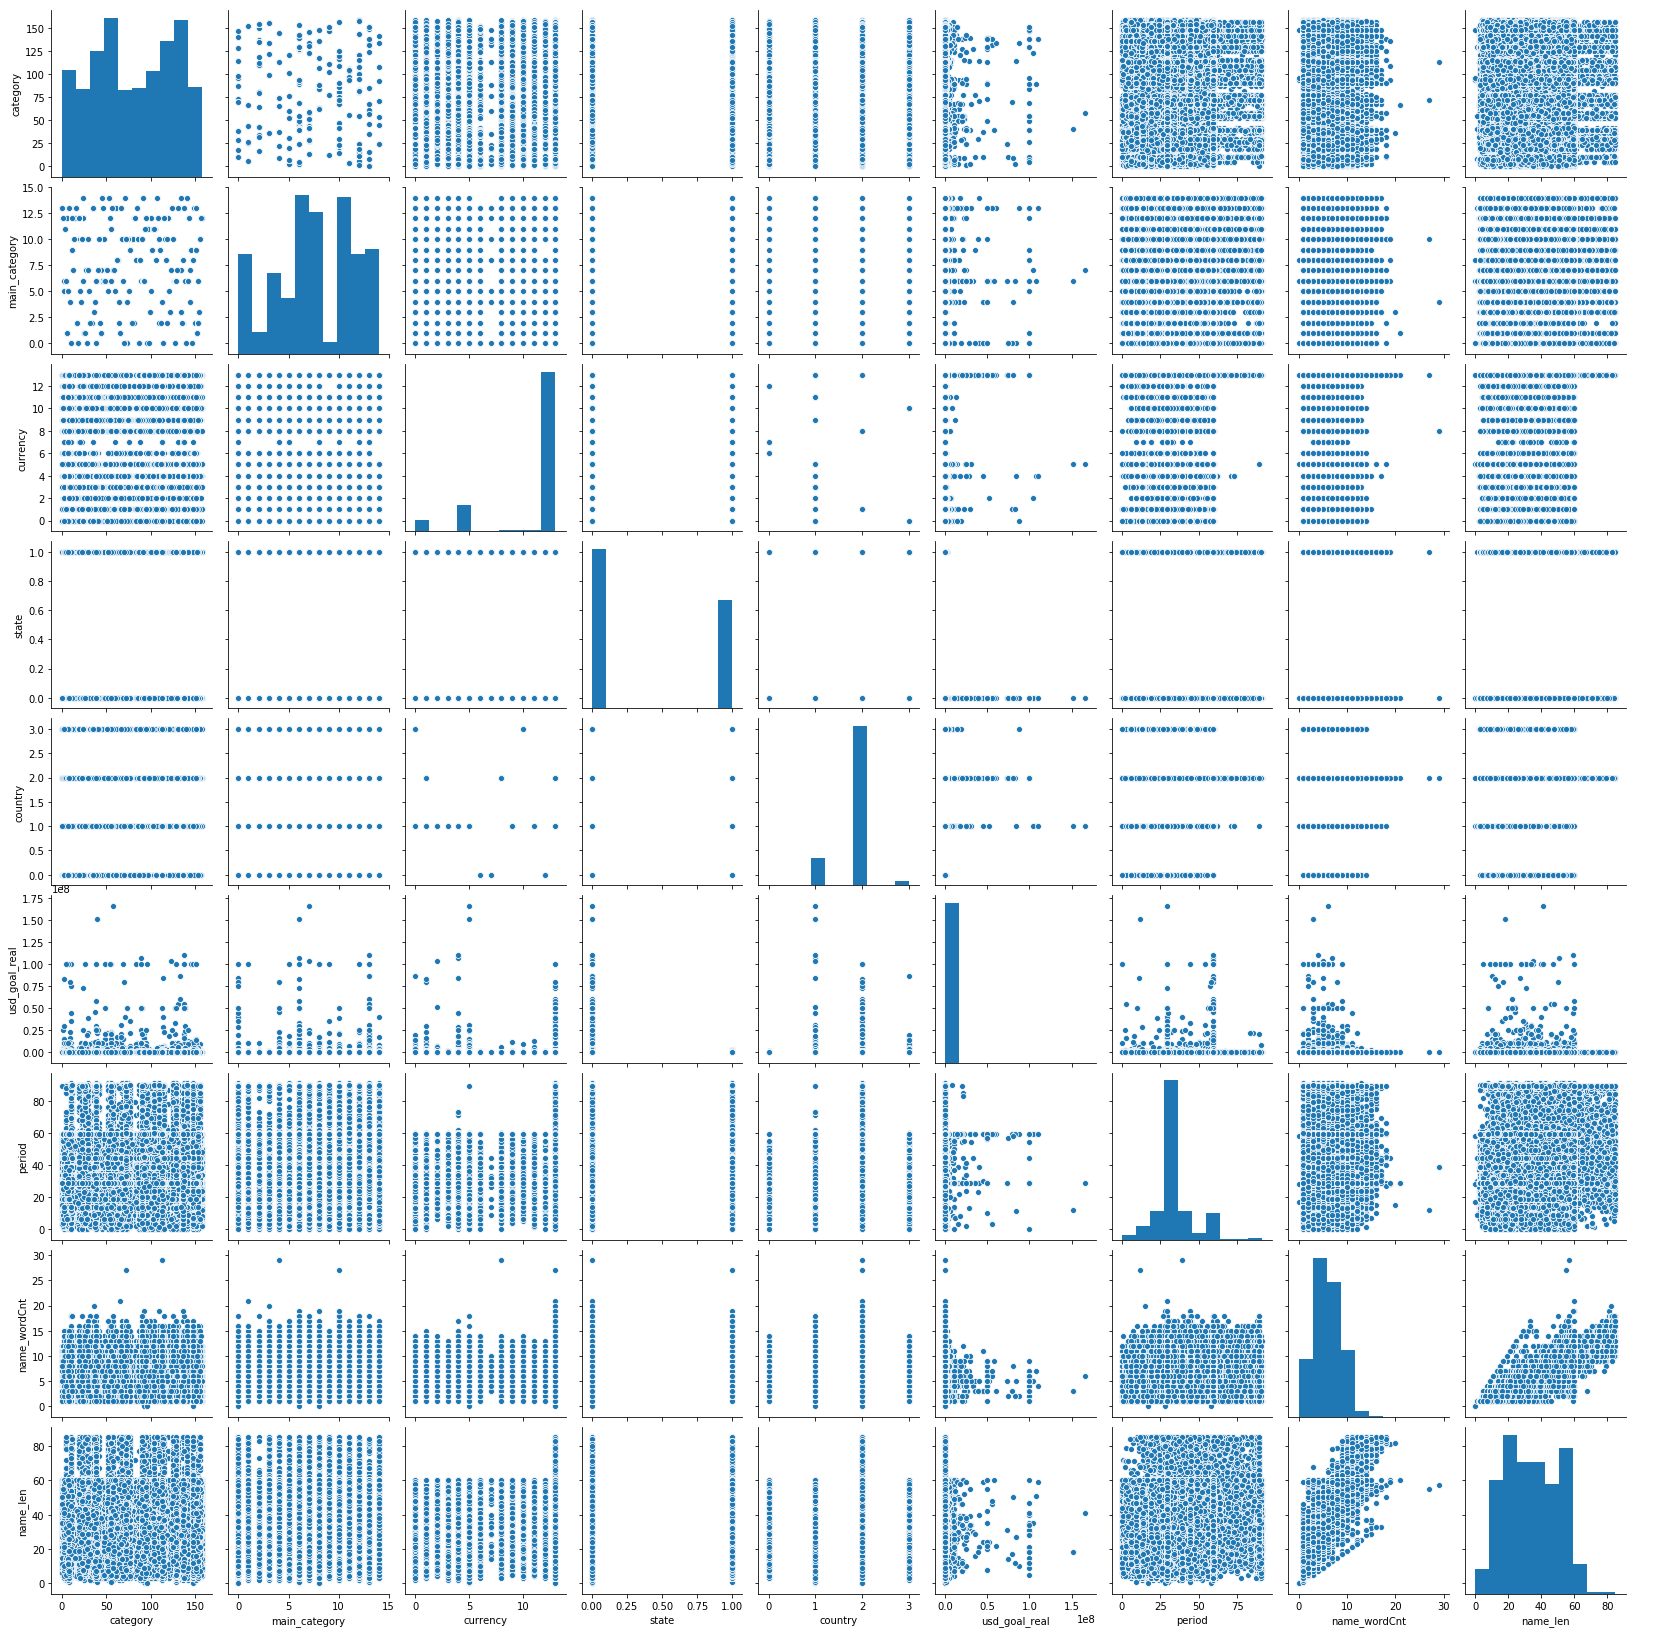

In [74]:
#散布図行列　ヒストグラムと散布図を全てのデータで表示
sns.pairplot(df_kp2[["category","main_category","currency","state","country","usd_goal_real","period","name_wordCnt","name_len"]])

- 散布図行列より、stateと相関がありそうなのは category, usd_goal_real, period, name_wordCnt(nameの単語数), name_len(nameの文字数)？
- period(クラウドファンディングの日数)のヒストグラムより、日数が長いデータ（右端）に外れ値がありそう？

## 文字データをダミー変数に置き換えて、モデル作成
### 13.文字データをダミー変数に置き換え

In [25]:
#以下のpd.get_dummies(df_kp)を実行するとメモリーエラーになったため、1列ずつダミー変数に置き換える
#df_kp=pd.get_dummies(df_kp)

#categoryはデータ数が多いため、今回はmain_categoryを使用する
#main_categoryをダミー変数に置き換える
df_kp_main_category=pd.get_dummies(df_kp.main_category,prefix="main_category")

#currencyをダミー変数に置き換える
df_kp_currency=pd.get_dummies(df_kp.currency,prefix="currency")

#countryをダミー変数に置き換える
df_kp_country=pd.get_dummies(df_kp.country,prefix="country")

In [26]:
#main_categoryのダミー変数
display(df_kp_main_category.head())

,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [27]:
#currencyのダミー変数
display(df_kp_currency.head())

,currency_AUD,currency_CAD,currency_CHF,currency_DKK,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [28]:
#countryのダミー変数
display(df_kp_country.head())

,country_Asia,country_Europe,country_North_America,country_Oceania
0,0,1,0,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
5,0,0,1,0


In [29]:
#ダミー変数で作成したDataFrameを結合
df_kp3=pd.concat([df_kp,  df_kp_main_category], axis=1)
df_kp3=pd.concat([df_kp3, df_kp_currency], axis=1)
df_kp3=pd.concat([df_kp3, df_kp_country], axis=1)
display(df_kp3.head())
df_kp3.info()

,name,category,main_category,currency,state,country,usd_goal_real,period,name_wordCnt,name_len,...,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD,country_Asia,country_Europe,country_North_America,country_Oceania
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,0,Europe,1533.95,58,6,31,...,0,0,0,0,0,0,0,1,0,0
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,0,North_America,30000.00,59,8,45,...,0,0,0,0,0,1,0,0,1,0
2,Where is Hank?,Narrative Film,Film & Video,USD,0,North_America,45000.00,44,3,14,...,0,0,0,0,0,1,0,0,1,0
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,0,North_America,5000.00,29,7,49,...,0,0,0,0,0,1,0,0,1,0
5,Monarch Espresso Bar,Restaurants,Food,USD,1,North_America,50000.00,34,3,20,...,0,0,0,0,0,1,0,0,1,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 43 columns):
name                          331675 non-null object
category                      331675 non-null object
main_category                 331675 non-null object
currency                      331675 non-null object
state                         331675 non-null int64
country                       331675 non-null object
usd_goal_real                 331675 non-null float64
period                        331675 non-null int64
name_wordCnt                  331675 non-null int64
name_len                      331675 non-null int64
main_category_Art             331675 non-null uint8
main_category_Comics          331675 non-null uint8
main_category_Crafts          331675 non-null uint8
main_category_Dance           331675 non-null uint8
main_category_Design          331675 non-null uint8
main_category_Fashion         331675 non-null uint8
main_category_Film & Video    331675 non-null uint

### 14.不要列の削除

In [30]:
#不要列の削除
#ダミー変数にしたため、object型の列を削除
#categoryはデータ数が多いため、今回はmain_categoryを使用する
df_kp3=df_kp3.drop(columns=['name', 'country', 'category', 'main_category', 'currency'])
display(df_kp3.head())
df_kp3.info()

,state,usd_goal_real,period,name_wordCnt,name_len,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,...,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD,country_Asia,country_Europe,country_North_America,country_Oceania
0,0,1533.95,58,6,31,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,30000.00,59,8,45,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,0,45000.00,44,3,14,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,0,5000.00,29,7,49,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
5,1,50000.00,34,3,20,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 38 columns):
state                         331675 non-null int64
usd_goal_real                 331675 non-null float64
period                        331675 non-null int64
name_wordCnt                  331675 non-null int64
name_len                      331675 non-null int64
main_category_Art             331675 non-null uint8
main_category_Comics          331675 non-null uint8
main_category_Crafts          331675 non-null uint8
main_category_Dance           331675 non-null uint8
main_category_Design          331675 non-null uint8
main_category_Fashion         331675 non-null uint8
main_category_Film & Video    331675 non-null uint8
main_category_Food            331675 non-null uint8
main_category_Games           331675 non-null uint8
main_category_Journalism      331675 non-null uint8
main_category_Music           331675 non-null uint8
main_category_Photography     331675 non-null uint8
mai

- 全て数値型のデータになったことを確認

## ①Scikit-learnを用いてロジスティック回帰を実装　※Day1時の精度
- stateが1になるかどうかを予測     
- とりあえず全て説明変数に使用して、ロジスティック回帰を実装
- モデルに特別な工夫はしない

In [31]:
#y:目的変数、X:説明変数
y = df_kp3["state"].values
X = df_kp3.drop("state",axis=1).values
#loss=log(ロジスティック回帰)
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
#学習する=fix
clf.fit(X, y)

# 重みを取得して表示
#w0 = clf.intercept_[0]
#w1 = clf.coef_[0, 0]
#w2 = clf.coef_[0, 1]
#print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}".format(w0, w1, w2))

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [33]:
# ラベルを予測
y_est = clf.predict(X)

# 確率値を得る
y_est_proba = clf.predict_proba(X)

# 対数尤度を表示
# log_lossは「負の」対数尤度を計算する関数であるため， - をつけて戻している
# normalizeという引数をTrueのままにしておくと、合計の対数尤度ではなく平均の対数尤度が計算されるので注意
print('【ロジスティック回帰のみの結果】')
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est_proba, normalize=False))) 

# 自分で対数尤度を計算
l = 0
epsilon = 1e-15
for i in range(len(y)):
    l += y[i] * np.log(y_est_proba[i,1] + epsilon) + (1 - y[i]) * np.log(y_est_proba[i,0] + epsilon)
print('対数尤度 = {:.3f}'.format(l))

print('識別精度 = ', clf.score(X, y))
# 正答率を表示
print('正答率（accuracy）  = {:.3f}%'.format(100 * accuracy_score(y, y_est)))
# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)
# 「クラウドファンデイングが成功する」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall）    = {:.3f}%'.format(100 * recall[1]))
print('F1値　（F1-score）  = {:.3f}%'.format(100 * f1_score[1]))

【ロジスティック回帰のみの結果】
対数尤度 = -5016653.655
対数尤度 = -5016653.655
識別精度 =  0.5620803497399562
正答率（accuracy）  = 56.208%
適合率（Precision） = 47.390%
再現率（Recall）    = 76.519%
F1値　（F1-score）  = 58.531%


In [34]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

,予測 = 失敗,予測 = 成功
正解 = 失敗,83926,113793
正解 = 成功,31454,102502


- ロジスティック回帰のみの場合、識別精度は56.208％になった。

## ②ホールドアウト法＋ロジスティック回帰を行い、汎化性能を確認
- ホールドアウト法で学習データを80%、テストデータを20%に分割して汎化性能を確認
- モデルはロジスティック回帰を使用

In [35]:
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.preprocessing import StandardScaler

#y:目的変数、X:説明変数
y = df_kp3["state"].values
X = df_kp3.drop("state",axis=1).values

# 全データのうち、20%をテストデータにする
test_size = 0.2

# ホールドアウト法を実行（テストデータはランダム選択）
#X_train：学習用データの説明変数
#X_test ：テスト用データの説明変数
#y_train：学習用データの目的変数
#y_test ：テスト用データの目的変数
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

# 学習用データを使ってロジスティック回帰モデルを学習
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
# 学習する
clf.fit(X_train, y_train)

# 重みを取得して表示
#w0 = clf.intercept_[0]
#w1 = clf.coef_[0, 0]
#w2 = clf.coef_[0, 1]
#print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}".format(w0, w1, w2))

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [36]:
# 学習用データに対する予測を実行
y_est_train = clf.predict(X_train)

# 確率値を得る
y_est_proba_train = clf.predict_proba(X_train)

# 対数尤度を表示
# log_lossは「負の」対数尤度を計算する関数であるため， - をつけて戻している
# normalizeという引数をTrueのままにしておくと、合計の対数尤度ではなく平均の対数尤度が計算されるので注意
print('【ホールドアウト法＋ロジスティック回帰の結果】')
print('学習用データの対数尤度 = {:.3f}'.format(- log_loss(y_train, y_est_proba_train, normalize=False))) 

# 自分で対数尤度を計算
l = 0
epsilon = 1e-15
for i in range(len(y_train)):
    l += y_train[i] * np.log(y_est_proba_train[i,1] + epsilon) + (1 - y[i]) * np.log(y_est_proba_train[i,0] + epsilon)
print('学習用データの対数尤度 = {:.3f}'.format(l))

print('識別精度 = ', clf.score(X_train, y_train))
# 学習用データに対する正答率を表示
print('学習用データの正答率（accuracy）  = {:.3f}%'.format(100 * accuracy_score(y_train, y_est_train)))
# 学習用データに対するPrecision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, y_est_train)
# 「クラウドファンデイングが成功する」に関するPrecision, Recall, F1-scoreを表示
print('学習用データの適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('学習用データの再現率（Recall）    = {:.3f}%'.format(100 * recall[1]))
print('学習用データのF1値　（F1-score）  = {:.3f}%'.format(100 * f1_score[1]))

【ホールドアウト法＋ロジスティック回帰の結果】
学習用データの対数尤度 = -3923338.046
学習用データの対数尤度 = -4356488.840
識別精度 =  0.5718964347629456
学習用データの正答率（accuracy）  = 57.190%
学習用データの適合率（Precision） = 48.083%
学習用データの再現率（Recall）    = 72.953%
学習用データのF1値　（F1-score）  = 57.963%


In [38]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = pd.DataFrame(confusion_matrix(y_train, y_est_train), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

,予測 = 失敗,予測 = 成功
正解 = 失敗,73433,84558
正解 = 成功,29035,78314


In [39]:
# テストデータに対する予測を実行
y_est_test = clf.predict(X_test)

# 確率値を得る
y_est_proba_test = clf.predict_proba(X_test)

# 対数尤度を表示
# log_lossは「負の」対数尤度を計算する関数であるため， - をつけて戻している
# normalizeという引数をTrueのままにしておくと、合計の対数尤度ではなく平均の対数尤度が計算されるので注意
print('【ホールドアウト法＋ロジスティック回帰の結果】')
print('テスト用データの対数尤度 = {:.3f}'.format(- log_loss(y_test, y_est_proba_test, normalize=False))) 

# 自分で対数尤度を計算
l = 0
epsilon = 1e-15
for i in range(len(y_test)):
    l += y_test[i] * np.log(y_est_proba_test[i,1] + epsilon) + (1 - y[i]) * np.log(y_est_proba_test[i,0] + epsilon)
print('テスト用データの対数尤度 = {:.3f}'.format(l))

print('識別精度 = ', clf.score(X_test, y_test))
# テスト用データに対する正答率を表示
print('テスト用データの正答率（accuracy）  = {:.3f}%'.format(100 * accuracy_score(y_test, y_est_test)))
# テスト用データに対するPrecision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_est_test)
# 「クラウドファンデイングが成功する」に関するPrecision, Recall, F1-scoreを表示
print('テスト用データの適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('テスト用データの再現率（Recall）    = {:.3f}%'.format(100 * recall[1]))
print('テスト用データのF1値　（F1-score）  = {:.3f}%'.format(100 * f1_score[1]))

【ホールドアウト法＋ロジスティック回帰の結果】
テスト用データの対数尤度 = -977654.605
テスト用データの対数尤度 = -1076987.925
識別精度 =  0.573287103339112
テスト用データの正答率（accuracy）  = 57.329%
テスト用データの適合率（Precision） = 47.907%
テスト用データの再現率（Recall）    = 73.082%
テスト用データのF1値　（F1-score）  = 57.875%


In [40]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est_test), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

,予測 = 失敗,予測 = 成功
正解 = 失敗,18584,21144
正解 = 成功,7162,19445


- ホールドアウト法＋ロジスティック回帰の場合、識別精度は57.329％になった。
- ロジスティック回帰のみ（56.208％）と比較して、精度が1.121％上がった。
- 学習用データの正答率（57.190%）< テスト用データの正答率（57.329%）より、テスト用データの正答率の方が大きいため「過学習ぎみ」
- 過学習のため、「正則化」をして過学習を抑制する。

## ③ホールドアウト法＋ロジスティック回帰＋L1正則化を行う
- ホールドアウト法で学習データを80%、テストデータを20%に分割して汎化性能を確認
- モデルはロジスティック回帰を使用
- L1正則化はロジスティック回帰のパラメータで実装

In [41]:
#y:目的変数、X:説明変数
y = df_kp3["state"].values
X = df_kp3.drop("state",axis=1).values

# 全データのうち、20%をテストデータにする
test_size = 0.2

# ホールドアウト法を実行（テストデータはランダム選択）
#X_train：学習用データの説明変数
#X_test ：テスト用データの説明変数
#y_train：学習用データの目的変数
#y_test ：テスト用データの目的変数
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

# 学習用データを使ってロジスティック回帰モデルを学習（L1正則化）
clf = SGDClassifier(loss='log', penalty='l1', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
# 学習する
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [42]:
# 学習用データに対する予測を実行(L1正則化)
y_est_train = clf.predict(X_train)

# 確率値を得る
y_est_proba_train = clf.predict_proba(X_train)

# 対数尤度を表示
# log_lossは「負の」対数尤度を計算する関数であるため， - をつけて戻している
# normalizeという引数をTrueのままにしておくと、合計の対数尤度ではなく平均の対数尤度が計算されるので注意
print('【ホールドアウト法＋ロジスティック回帰＋L1正則化の結果】')
print('学習用データの対数尤度 = {:.3f}'.format(- log_loss(y_train, y_est_proba_train, normalize=False))) 

# 自分で対数尤度を計算
l = 0
epsilon = 1e-15
for i in range(len(y_train)):
    l += y_train[i] * np.log(y_est_proba_train[i,1] + epsilon) + (1 - y_train[i]) * np.log(y_est_proba_train[i,0] + epsilon)
print('学習用データの対数尤度 = {:.3f}'.format(l))

print('識別精度 = ', clf.score(X_test, y_test))
# 学習用データに対する正答率を表示
print('学習用データの正答率（accuracy）  = {:.3f}%'.format(100 * accuracy_score(y_train, y_est_train)))
# 学習用データに対するPrecision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, y_est_train)
# 「クラウドファンデイングが成功する」に関するPrecision, Recall, F1-scoreを表示
print('学習用データの適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('学習用データの再現率（Recall）    = {:.3f}%'.format(100 * recall[1]))
print('学習用データのF1値　（F1-score）  = {:.3f}%'.format(100 * f1_score[1]))

【ホールドアウト法＋ロジスティック回帰＋L1正則化の結果】
学習用データの対数尤度 = -3927680.574
学習用データの対数尤度 = -3927680.574
識別精度 =  0.5727444034069495
学習用データの正答率（accuracy）  = 57.143%
学習用データの適合率（Precision） = 48.050%
学習用データの再現率（Recall）    = 73.110%
学習用データのF1値　（F1-score）  = 57.989%


In [43]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = pd.DataFrame(confusion_matrix(y_train, y_est_train), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

,予測 = 失敗,予測 = 成功
正解 = 失敗,73139,84852
正解 = 成功,28866,78483


In [44]:
# テストデータに対する予測を実行(L1正則化)
y_est_test = clf.predict(X_test)

# 確率値を得る
y_est_proba_test = clf.predict_proba(X_test)

# 対数尤度を表示
# log_lossは「負の」対数尤度を計算する関数であるため， - をつけて戻している
# normalizeという引数をTrueのままにしておくと、合計の対数尤度ではなく平均の対数尤度が計算されるので注意
print('【ホールドアウト法＋ロジスティック回帰＋L1正則化の結果】')
print('テスト用データの対数尤度 = {:.3f}'.format(- log_loss(y_test, y_est_proba_test, normalize=False))) 

# 自分で対数尤度を計算
l = 0
epsilon = 1e-15
for i in range(len(y_test)):
    l += y_test[i] * np.log(y_est_proba_test[i,1] + epsilon) + (1 - y_test[i]) * np.log(y_est_proba_test[i,0] + epsilon)
print('テスト用データの対数尤度 = {:.3f}'.format(l))

print('識別精度 = ', clf.score(X_test, y_test))
# テスト用データに対する正答率を表示
print('テスト用データの正答率（accuracy）  = {:.3f}%'.format(100 * accuracy_score(y_test, y_est_test)))
# テスト用データに対するPrecision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_est_test)
# 「クラウドファンデイングが成功する」に関するPrecision, Recall, F1-scoreを表示
print('テスト用データの適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('テスト用データの再現率（Recall）    = {:.3f}%'.format(100 * recall[1]))
print('テスト用データのF1値　（F1-score）  = {:.3f}%'.format(100 * f1_score[1]))

【ホールドアウト法＋ロジスティック回帰＋L1正則化の結果】
テスト用データの対数尤度 = -978898.001
テスト用データの対数尤度 = -978898.001
識別精度 =  0.5727444034069495
テスト用データの正答率（accuracy）  = 57.274%
テスト用データの適合率（Precision） = 47.870%
テスト用データの再現率（Recall）    = 73.270%
テスト用データのF1値　（F1-score）  = 57.907%


In [45]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est_test), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

,予測 = 失敗,予測 = 成功
正解 = 失敗,18498,21230
正解 = 成功,7112,19495


- ホールドアウト法＋ロジスティック回帰＋L1正則化の場合、識別精度は57.274％になった。
- ロジスティック回帰のみ（56.208％）と比較して、精度が1.066％上がった。
- ホールドアウト法＋ロジスティック回帰（57.329％）と比較して、精度が0.055％下がった。

## ④ホールドアウト法＋ロジスティック回帰＋L1正則化＋標準化を行う
- ホールドアウト法で学習データを80%、テストデータを20%に分割して汎化性能を確認
- モデルはロジスティック回帰を使用
- L1正則化はロジスティック回帰のパラメータで実装
- 標準化を行い、スケール変換する（前処理）

In [46]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#y:目的変数、X:説明変数
y = df_kp3["state"].values
X = df_kp3.drop("state",axis=1).values

# 全データのうち、20%をテストデータにする
test_size = 0.2

# ホールドアウト法を実行（テストデータはランダム選択）
#X_train：学習用データの説明変数
#X_test ：テスト用データの説明変数
#y_train：学習用データの目的変数
#y_test ：テスト用データの目的変数
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

#標準化
stdsc = StandardScaler()
#学習用データの標準化
X_train = stdsc.fit_transform(X_train)
#テスト用データの標準化
X_test = stdsc.transform(X_test)

# 学習用データを使ってロジスティック回帰モデルを学習（L1正則化）
clf = SGDClassifier(loss='log', penalty='l1', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
# L1正則化＋標準化したデータで学習する
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [47]:
# 学習用データに対する予測を実行(L1正則化＋標準化)
y_est_train = clf.predict(X_train)

# 確率値を得る
y_est_proba_train = clf.predict_proba(X_train)

# 対数尤度を表示
# log_lossは「負の」対数尤度を計算する関数であるため， - をつけて戻している
# normalizeという引数をTrueのままにしておくと、合計の対数尤度ではなく平均の対数尤度が計算されるので注意
print('【ホールドアウト法＋ロジスティック回帰＋L1正則化＋標準化の結果】')
print('学習用データの対数尤度 = {:.3f}'.format(- log_loss(y_train, y_est_proba_train, normalize=False))) 

# 自分で対数尤度を計算
l = 0
epsilon = 1e-15
for i in range(len(y_train)):
    l += y_train[i] * np.log(y_est_proba_train[i,1] + epsilon) + (1 - y_train[i]) * np.log(y_est_proba_train[i,0] + epsilon)
print('学習用データの対数尤度 = {:.3f}'.format(l))

print('識別精度 = ', clf.score(X_test, y_test))
# 学習用データに対する正答率を表示
print('学習用データの正答率（accuracy）  = {:.3f}%'.format(100 * accuracy_score(y_train, y_est_train)))
# 学習用データに対するPrecision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, y_est_train)
# 「クラウドファンデイングが成功する」に関するPrecision, Recall, F1-scoreを表示
print('学習用データの適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('学習用データの再現率（Recall）    = {:.3f}%'.format(100 * recall[1]))
print('学習用データのF1値　（F1-score）  = {:.3f}%'.format(100 * f1_score[1]))

【ホールドアウト法＋ロジスティック回帰＋L1正則化＋標準化の結果】
学習用データの対数尤度 = -165790.854
学習用データの対数尤度 = -165789.656
識別精度 =  0.651933368508329
学習用データの正答率（accuracy）  = 64.697%
学習用データの適合率（Precision） = 58.267%
学習用データの再現率（Recall）    = 44.897%
学習用データのF1値　（F1-score）  = 50.716%


In [48]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = pd.DataFrame(confusion_matrix(y_train, y_est_train), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

,予測 = 失敗,予測 = 成功
正解 = 失敗,123470,34521
正解 = 成功,59152,48197


In [49]:
# テストデータに対する予測を実行(L1正則化＋標準化)
y_est_test = clf.predict(X_test)

# 確率値を得る
y_est_proba_test = clf.predict_proba(X_test)

# 対数尤度を表示
# log_lossは「負の」対数尤度を計算する関数であるため， - をつけて戻している
# normalizeという引数をTrueのままにしておくと、合計の対数尤度ではなく平均の対数尤度が計算されるので注意
print('【ホールドアウト法＋ロジスティック回帰＋L1正則化＋標準化の結果】')
print('テスト用データの対数尤度 = {:.3f}'.format(- log_loss(y_test, y_est_proba_test, normalize=False))) 

# 自分で対数尤度を計算
l = 0
epsilon = 1e-15
for i in range(len(y_test)):
    l += y_test[i] * np.log(y_est_proba_test[i,1] + epsilon) + (1 - y_test[i]) * np.log(y_est_proba_test[i,0] + epsilon)
print('テスト用データの対数尤度 = {:.3f}'.format(l))

print('識別精度 = ', clf.score(X_test, y_test))
# テスト用データに対する正答率を表示
print('テスト用データの正答率（accuracy）  = {:.3f}%'.format(100 * accuracy_score(y_test, y_est_test)))
# テスト用データに対するPrecision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_est_test)
# 「クラウドファンデイングが成功する」に関するPrecision, Recall, F1-scoreを表示
print('テスト用データの適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('テスト用データの再現率（Recall）    = {:.3f}%'.format(100 * recall[1]))
print('テスト用データのF1値　（F1-score）  = {:.3f}%'.format(100 * f1_score[1]))

【ホールドアウト法＋ロジスティック回帰＋L1正則化＋標準化の結果】
テスト用データの対数尤度 = -41299.205
テスト用データの対数尤度 = -41298.950
識別精度 =  0.651933368508329
テスト用データの正答率（accuracy）  = 65.193%
テスト用データの適合率（Precision） = 58.509%
テスト用データの再現率（Recall）    = 45.458%
テスト用データのF1値　（F1-score）  = 51.164%


In [50]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est_test), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

,予測 = 失敗,予測 = 成功
正解 = 失敗,31151,8577
正解 = 成功,14512,12095


- ホールドアウト法＋ロジスティック回帰＋L1正則化＋標準化の場合、識別精度は65.193％になった。
- ロジスティック回帰のみ（56.208％）と比較して、精度が8.985％上がった。
- ホールドアウト法＋ロジスティック回帰（57.329％）と比較して、精度が7.864％上がった。
- ホールドアウト法＋ロジスティック回帰＋L1正則化（57.274％）と比較して、精度が7.919％上がった。

## ⑤SVM＋ハイパーパラメータチューニングを行う
- SVMにモデルを変更して精度を確認
- SVMは計算時間が長いため、サンプリングして計算時間を短くさせる
- グリッドサーチを使って、ハイパーパラメータチューニングを行う

In [51]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC #SVMを計算

#y:目的変数、X:説明変数
y = df_kp3["state"].values
X = df_kp3.drop("state",axis=1).values

# 全データのうち、20%をテストデータにする
test_size = 0.2

# ホールドアウト法を実行（テストデータはランダム選択）
#X_train：学習用データの説明変数
#X_test ：テスト用データの説明変数
#y_train：学習用データの目的変数
#y_test ：テスト用データの目的変数
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

#標準化
stdsc = StandardScaler()
#学習用データの標準化
X_train = stdsc.fit_transform(X_train)
#テスト用データの標準化
X_test = stdsc.transform(X_test)

#学習用データの中から、2%をサンプリングする　※SVMは計算時間が長いためサンプリングして計算時間を短くさせる
X_train_grid = pd.DataFrame(X_train).sample(frac = 0.02, random_state=1234)
y_train_grid = pd.DataFrame(y_train).sample(frac = 0.02, random_state=1234)

# SVM（サポートベクターマシン）の実行
#linear＝線形
#rbf＝ガウスカーネル関数（非線形カーネル）
parameters = {'kernel':['linear', 'rbf'], 'C':[0.5, 1, 1.5]}
model = SVC(random_state=1234)
#グリッドサーチ
#最適化したいパラメータセット
#cv＝交差検定の回数（2回）
clf = GridSearchCV(model, parameters, cv=2, return_train_score=False)
#学習させる
clf.fit(X_train_grid, y_train_grid)
# 学習用データに対する予測を実行
y_est_train = clf.predict(X_train_grid)
print(clf.best_params_, clf.best_score_)

C:\Users\maki\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\maki\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\maki\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\maki\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gam

{'C': 1.5, 'kernel': 'rbf'} 0.6449971735443754


In [53]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = pd.DataFrame(confusion_matrix(y_train_grid, y_est_train), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

,予測 = 失敗,予測 = 成功
正解 = 失敗,2719,468
正解 = 成功,1338,782


In [54]:
#学習用データの中から、15%をサンプリングする　※SVMは計算時間が長いためサンプリングして計算時間を短くさせる
X_train_sample = pd.DataFrame(X_train).sample(frac = 0.15, random_state=1234)
y_train_sample = pd.DataFrame(y_train).sample(frac = 0.15, random_state=1234)

# 最適パラメータを用いてSVMを実行
clf2 = SVC(**clf.best_params_, random_state=1234)
#学習させる
clf2.fit(X_train_sample, y_train_sample) 
# テスト用データに対する予測を実行
y_est_test = clf2.predict(X_test)

#テスト用データで精度確認
print('【SVM＋ハイパーパラメータチューニングの結果】')
print('識別精度 = ', clf2.score(X_test, y_test))

C:\Users\maki\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\maki\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


【SVM＋ハイパーパラメータチューニングの結果】
識別精度 =  0.6426320946709881


In [55]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est_test), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

,予測 = 失敗,予測 = 成功
正解 = 失敗,33697,6031
正解 = 成功,17675,8932


- SVM＋ハイパーパラメータチューニングの場合、識別精度は64.263％になった。
- 最適なパラメータは「C:1.5、kernel:rbf」になった。
- ホールドアウト法＋ロジスティック回帰＋L1正則化＋標準化（65.193％）と比較して、精度が0.93％下がった。

## まとめ
- テストデータの精度が一番高いモデルは「ホールドアウト法＋ロジスティック回帰＋L1正則化＋標準化」で識別精度は65.193％になった。
- DAY1宿題提出時（ノーマルなロジスティック回帰のモデル）の精度（56.208％）と比較して、精度が8.985％上がった。
- Precisionが一番高いモデルは「ホールドアウト法＋ロジスティック回帰＋L1正則化＋標準化」で58.509％になった。
- Recallが一番高いモデルは「ロジスティック回帰のみ」で76.519％になった。取りこぼしが少ないモデルは「ロジスティック回帰のみ」。
- 「SVM＋ハイパーパラメータチューニング」のモデルの精度（64.263％）は期待していたよりも低かった。
- SVMは計算時間がかかるため、サンプリングでデータ数を少なくしたため、学習がうまくいかなかったと思われる。また、ハイパーパラメータの調整が必要。